# Bathymetric Data Visualization
### Objective(s) for this notebook:
- Download a small tile from _WCS_ & attempt to make successive contours from it with a contour making function, which exports a list or set of contours in vector format
- Then, try to stich together _WCS_ tiles to create the entire Mediterranean raster
- Acquire, plot, and export contours for this stitch

In [1]:
# You can find more detail on these libraries by consulting my install script or
# visiting their page on CRAN.
library(XML)
library(ncdf4)
library(sp)
library(lattice)
library(terra)
library(downloader)
library(ggplot2)
library(directlabels)
library(rasterVis)
library(raster)
library(gdalUtilities)
library(reshape2)
library(viridis);

terra 1.7.55

Loading required package: viridisLite



## Downloading a tile:

To give some perspective, the small area we intend to query here is $2.5$ by $2.5$ degrees and an arc minute is $\frac{1}{60}$ of a degree, so:

- At a resolution of 1/8 arc minute, there would be $8\times 60\times 2.5=1200$ samples across each axis, for a total of $1,440,000$ total samples
- At a resolution of 1/16 arc minute, there would be $24$ (twice as many) samples across each axis, for a total of $5,670,000$ total samples

In [2]:
# Set a bounding box for the Thermaic Gulf:
xmin <- 22.0
xmax <- 24.5
ymin <- 39.0
ymax <- 41.0

In [3]:
get_bathymetry_tile <- function(name, xmin, xmax, ymin, ymax, resx = 1, resy = 1) {
  bounding_box <- paste(xmin, ymin, xmax, ymax, sep = ",")
  url <- paste("https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=",
               name, "&crs=EPSG:4326&BBOX=", bounding_box,
               "&format=image/tiff&interpolation=nearest&resx=", resx, "&resy=", resy,
               sep = "")
  print(paste("Full Request URL:", url))
  temp <- paste(name, "img.tiff", sep = "_")
  temp <- tempfile(temp)
  download.file(url, temp, quiet = FALSE, mode = "wb")
  img_raw <- raster::raster(temp)
  img_raw <- -1 * img_raw
  img_raw[img_raw < 0] <- 0 # (any heights above sea level become 0)
  img_raw[img_raw == 0] <- NaN # (any coastlines are marked with NaN)
  return(img_raw)
}

In [4]:
img <- get_bathymetry_tile(name="emodnet:mean", xmin, xmax, ymin, ymax, resx = 0.001, resy = 0.001)

[1] "Full Request URL: https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=emodnet:mean&crs=EPSG:4326&BBOX=22,39,24.5,41&format=image/tiff&interpolation=nearest&resx=0.001&resy=0.001"


In [8]:
bathy_df <- as.data.frame(as(img, "SpatialPixelsDataFrame"))

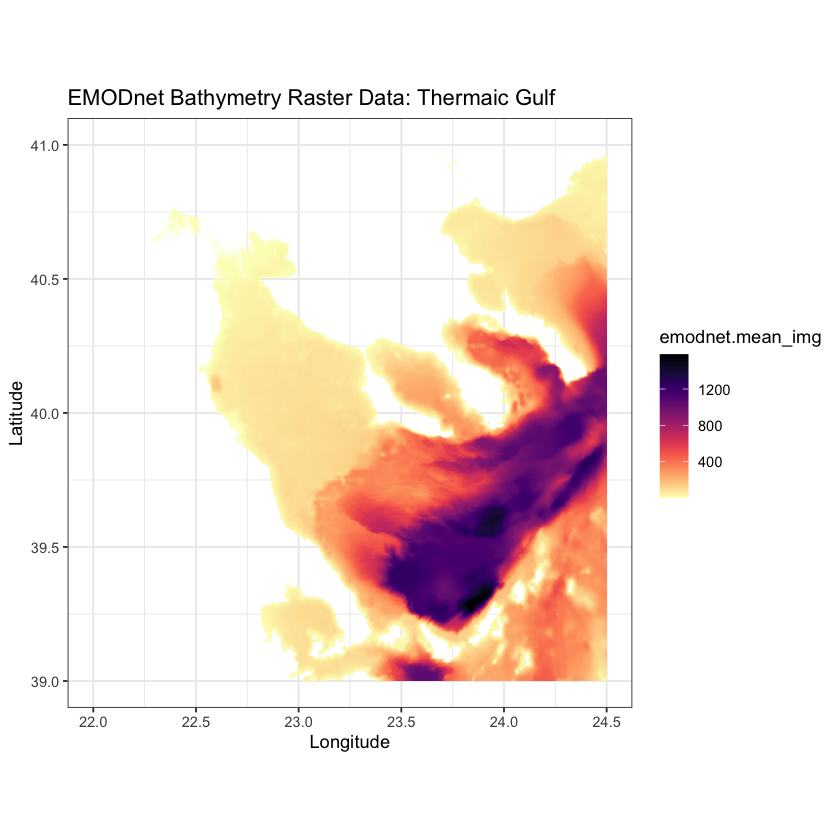

In [11]:
map <- ggplot(aes(x = x, y = y, z = emodnet.mean_img), data = bathy_df) +
  geom_tile(data = bathy_df, aes(fill = emodnet.mean_img)) +
  #scale_fill_gradient(low = "#0097ea", high = "#1f1820", name = "Depth (m)") +
  scale_fill_viridis(option = "A", direction = -1) + # magma colormap
  coord_quickmap(xlim = range(xmin, xmax), ylim = range(ymin, ymax)) +
  ggtitle("EMODnet Bathymetry Raster Data: Thermaic Gulf") +
  xlab("Longitude") +
  ylab("Latitude") +
  theme_bw()
map

## Creating contours:

In [5]:
dim(img)

[1] 2000 2500    1

it appears as if the specification of `res = 0.001` $\implies$ that there are 1000 samples per degree (.001 degrees of coverage per sample).

It looks like the data frame, structured `intensity, x, y` like `bathy_df` would be much easier to stitch together than a `RasterLayer` object that doesn't have easily-accessible coordinates.

I could do this several ways,
- I could simply collapse ranges of values (e.g `0-99.9 -> 0, 100-199.9 -> 100,...`) which would be nice because I could plot the same way,
- Or I could export layers as a list of separate images, because what I really want in the end is several images that I can play around with and rearrange in a graphics program

## First Method:

In [6]:
contour_fill_map <- function(n, interval = 100) {
  return(interval * (floor(n / interval)))
}

In [7]:
contour_transform <- function(img, interval = 100) {
  img_copy <- as.matrix(img) # S4 to matrix
  img_copy <- apply(img_copy, c(1, 2), 
                    function(x) contour_fill_map(x, interval = interval))
  return(img_copy)
}

In [8]:
img_contours <- contour_transform(img, interval = 250)

In [10]:
df_img_contours <- melt(apply(img_contours, c(2), rev), varnames = c("y", "x"), value.name = "z")

In [11]:
head(df_img_contours)

,y,x,z
,<int>,<int>,<dbl>
1,1,1,NaN
2,2,1,NaN
3,3,1,NaN
4,4,1,NaN
5,5,1,NaN
6,6,1,NaN


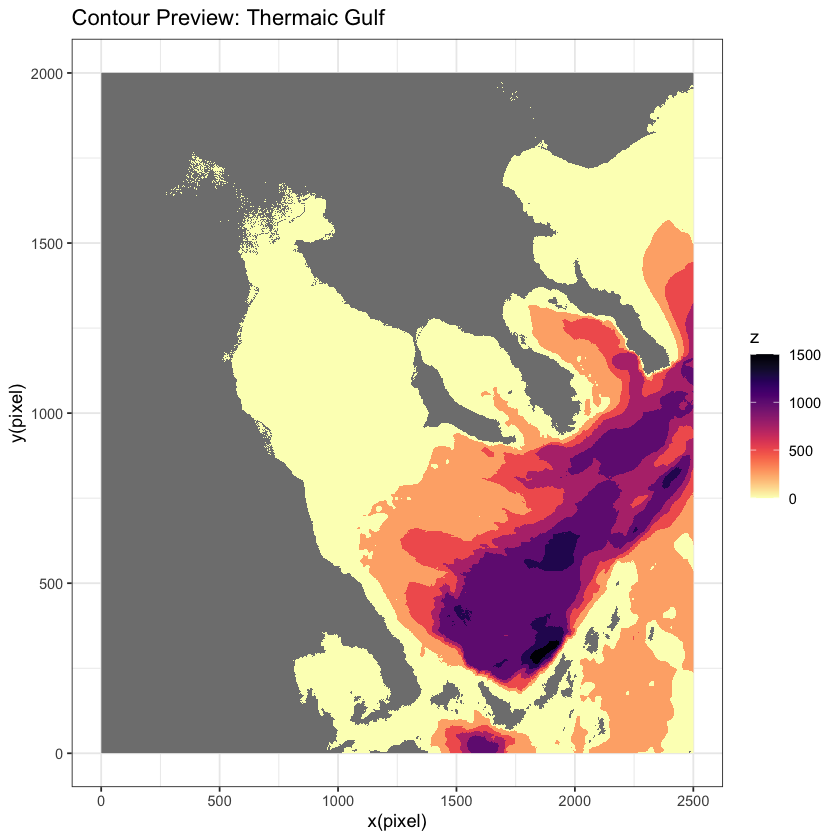

In [12]:
map <- ggplot(aes(x = x, y = y, z = z), data = df_img_contours) +
  # geom_tile(data = bathy_df, aes(fill = emodnet.mean_img)) +
  #scale_fill_gradient(low = "#0097ea", high = "#1f1820", name = "Depth (m)") +
  geom_raster(aes(fill = z)) +
  scale_fill_viridis(option = "A", direction = -1) + # magma colormap
  # coord_quickmap(xlim = range(xmin, xmax), ylim = range(ymin, ymax)) +
  ggtitle("Contour Preview: Thermaic Gulf") +
  xlab("x(pixel)") +
  ylab("y(pixel)") +
  theme_bw()
map

## Second Method:
### Pseudocode:
```R
stitch <- function(bounding box, tile size, resolutions) {
  create matrix size of bounding box
  print resolution
  for(i in seq(start, end, resolution*tile size)) {
    for(j in similar) {
      assign box to call of get_bathymetry_tile
    }
    print msg (1/...) tiles to go!
  }
  print(deepest depth)
  return(matrix)
}

create_and_export_contour_images <- function(matrix, numContours, basin depth) {
  for(contour in numContours) {
    calculate contour depth
    create new image matrix
    use apply fn to set 
    write to tiff and export
    print msg that you are (1/n) contours of the way through
  }
}
```

The necessity of this function comes from the fact that the _WCS_ will ding you for "too large a request" (even if your resolution is quite small), so I have to look for one smaller tile at a time, and then stitch them together to create a larger picture

In [85]:
stitch_tiles <- function(xmin, xmax, ymin, ymax, tile_size = 2.5, res = 100) {
  # @param: xmin, xmax, ymin, ymax should be a bounding box of latitude
  # and longitude
  # @param: tile_size should be a double in degrees such that describes how
  # large the tiles should be.  E.g: 2.5 => 2.5x2.5 degree tile of earth
  # @param: res should be values per degree.  E.g. 100 => there will be
  # 100x100 = 10,000 samples in a 1 degree by 1 degree tile.
  # @return: a matrix containing these tiles stitched together

  width_degrees <- xmax - xmin # width of entire area in degrees
  height_degrees <- ymax - ymin # height ''
  width_pixels <- width_degrees * res # width of entire area in pixels
  height_pixels <- height_degrees * res # height ''
  width_tiles <- ceiling(width_degrees / tile_size) # width of area in tiles
  height_tiles <- ceiling(height_degrees / tile_size) # height ''
  total_tiles <- width_tiles * height_tiles # total number of tiles
  tile_size_pixels <- tile_size * res # length of tile side in pixels

  cat(paste("The resulting image will be", width_degrees, "deg wide by",
            height_degrees, "deg tall,\n"))
  cat(paste(width_pixels, "pixels wide by", height_pixels, "pixels tall,\n"))
  cat(paste("and", width_tiles, "tiles wide by", height_tiles,
            "tiles tall.\n"))
  cat(paste("That's", total_tiles, "total tiles."))

  stitched_img <- matrix(0, height_pixels, width_pixels)

  cat("Beginning Stitching Process")
  Sys.sleep(0.1)
  p_bar <- txtProgressBar(style = 3)
  # This will be confusing: we are proceeding left to right, top to bottom
  # We finish one row, then move on to the next
  # But, matrices are accessed s.t. the top left corner is [0,0]
  # So "min" and "max" have different meanings, depending on the context
  for (row in 1:height_tiles) {
    # degree vars for data request:
    ymax_temp <- ymax - ((row - 1) * tile_size)
    ymin_temp <- ymax - (row * tile_size)
    # pixel vars for image:
    ymin_pixels <- 1 + ((row - 1) * tile_size_pixels)
    ymax_pixels <- (row * tile_size_pixels)
    for (col in 1:width_tiles) {
      # degree vars for data request:
      xmin_temp <- xmin + ((col - 1) * tile_size)
      xmax_temp <- xmin + (col * tile_size)
      # pixel vars for image:
      xmin_pixels <- 1 + ((col - 1) * tile_size_pixels)
      xmax_pixels <- (col * tile_size_pixels)
      # {request and assignment here}
      tile_num <- (row - 1) * width_tiles + col # what tile we are on
      setTxtProgressBar(p_bar, tile_num / total_tiles)
      Sys.sleep(2)
    }
  }
  Sys.sleep(0.5)
  close(p_bar)
  Sys.sleep(0.5)
  cat("Finished")
  return(stitched_img)
}

In [86]:
xmin <- -6
xmax <- 37
ymin <- 29
ymax <- 46

In [87]:
xmin <- 10
xmax <- 16
ymin <- 40
ymax <- 44

In [88]:
throwaway <- stitch_tiles(xmin, xmax, ymin, ymax, tile_size = 2, res = 100)

The resulting image will be 6 deg wide by 4 deg tall,
600 pixels wide by 400 pixels tall,
and 3 tiles wide by 2 tiles tall.
  |======================================================================| 100%
Finished

In [79]:
dim(throwaway)

[1] 400 600

## testing: 

In [82]:
throwaway[400, 500]

[1] 0

In [16]:
cat(paste("foo: ", "goo"))
Sys.sleep(1.0)
pf <- txtProgressBar(style = 3)
n <- 87
for (i in 1:n) {
  setTxtProgressBar(pf, i / n)
  Sys.sleep(0.05)
}
close(pf)
cat("goo")

foo:  goo

  |======================================================================| 100%
goo

In [83]:
foo <- matrix(1:6, 2, 3)
foo

1,3,5
2,4,6


In [84]:
foo[1,3]

[1] 5

In [34]:
goo <- foo[1, 1:2]
# first row(1), then column(2)
goo

[1] 1 3

In [36]:
is.matrix(goo)

[1] FALSE

In [37]:
foo[1, 1:2] <- c(9, 9)

In [75]:
foo[2, 1:2] <- foo[1, 1:2]

In [76]:
foo

9,9
9,9
